# Simulation-Based Inference SIR Model: Coverage Study
Created: June 8, 2022 Prosper, Prosper, and Ali Kadhim<br>

## Introduction 

In this notebook, we compute through explicit enumeration the coverage of the confidence sets constructed using model __SIR_dnn_cdf_NNNk.py__ (e.g., NNN=100).

Recall that our test statistic is

\begin{align}
    \lambda(\theta, \mathbf{x}) & = \sqrt{\frac{1}{n} \sum_{j=1}^n \frac{[x_j - I_j(\theta)]^2}{I_j}} ,
\end{align}

where $\mathbf{x} = x_1,\cdots,x_n$ are infection counts and $I_j = I(t_j, \theta)$ is the *mean* infection count at time $t_j$ found by solving the SIR equations

\begin{align}
    \frac{dS}{dt} & = - \beta S I ,\\
    \frac{dI}{dt} & = \beta S I - \alpha I .
\end{align}

Confidence sets are created through the repeated application of the level-$\alpha$ test $H_0: \theta = \theta_0$ versus the alternative $H_1: \theta \neq \theta_0$.
A __confidence set__ $R({\cal D})$, which is a random set by virtue of its dependence on potentially observable data ${\cal D}$, is the set of all values of $\theta$ that *fail to be rejected* by the level-$\alpha$ tests (here $\alpha$ is not to be confused with the SIR parameter).  The __confidence level__ (CL) of the confidence set is $\tau = 1 - \alpha$. If the coverage probability function (CPF), that is, the coverage probability of the infinite collection of confidence sets at a given point $\theta$ in the parameter space, satisfies the condition $\text{CPF}(\theta \in R({\cal D}) | \theta) \ge \tau$ then the confidence sets are said to be *exact*; otherwise they are approximate.


## Explicit checking of coverage

The notebook SIR_train_amortized_cdf.ipynb creates a model $M(\alpha, \beta, \lambda_0)$ that approximates $\mathbb{P}(\lambda \leq \lambda_0|\alpha, \beta, \lambda_0)$.  The figure below shows 
the SIR confidence sets, for different confidence levels, for the Boarding School data. The dashed contours are estimated through histogramming, while the continuous contours are the predictions of the simple deep neural network model $M(\alpha, \beta, \lambda_0)$. 

![model comparison](fig_SIR_dnn_amortized_cdf_3_50_50_50_1_ReLU.png)

### Coverage Algorithm
We compute the coverage, through explicit enumeration, with algorithm below.
  1. Sample $\theta_i = (\alpha_i, \beta_i) \sim \pi_\theta$ near the best fit point (specifically, within the 95\% CL confidence set for the Boarding School data).
  1. Compute the mean infection counts $\mathbf{I}_i = (I_1,\ldots, I_n)$ by solving the coupled ODEs.
  1. Generate data $\mathbf{D}_i = (x_1,\ldots,x_n) \sim F_{\theta_i}$ for $K$ epidemics.
  1. Sample confidence level $\tau_i \sim \text{uniform(0.5, 1)}$
  1. For each epidemic, $k$:
      1. Compute the test statistic $\lambda_{k} = \lambda(\theta_i, \mathbf{D}_k)$
      1. Compute $Z_k = \mathbb{I}[\, M(\theta_i, \lambda_k) \leq \tau_i\, ]$, where $\mathbb{I}$ is the indicator function. If $Z_k = 1$ then the point $\theta_i$ lies within the confidence set, with confidence level $\tau$, associated with the current epidemic, while if $Z_k = 0$ the point does not.
  1. Compute fraction $f_i = \text{sum}(Z) / K$, that is, the fraction of the time $\theta_i$ was within the confidence set.
  1. If $f_i \approx \tau_i$ then life is good!
  1. Repeat the above many times.

In [1]:
import os, sys
sys.path.append('../')

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# pytorch
import torch
import torch.nn as nn

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
#seed = 128
#rnd  = np.random.RandomState(seed)

### Load SIR data

In [3]:
from SIR_gen_util import SIRdata
print(SIRdata)

 D           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 I0          : 3
 O           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 R0          : 0
 S0          : 763
 T           : [ 0  2  3  4  5  6  7  8  9 10 11 12 13]
 alpha0      : 0.465
 alpha_bins  : 16
 alpha_max   : 1.0
 alpha_min   : 0.0
 alpha_scale : 1.0
 beta0       : 0.00237
 beta_bins   : 16
 beta_max    : 0.7
 beta_min    : 0.2
 beta_scale  : 0.005
 model       : SIR
 scale       : 50
 tmax        : 14.0
 tmin        : 0.0



### Load cdf model 

The model, $M$, approximates the probability

\begin{align}
    \mathbb{P}(\lambda \leq \lambda_0 | \alpha, \beta) & = M(\alpha, \beta, \lambda_0).
\end{align}

In [4]:
! ls ../models

__pycache__  SIR_dnn_cdf_100k.py  SIR_dnn_cdf_800K.py  SIR_dnn_quantile.py


In [5]:
sys.path.append('../models')

In [6]:
! cat ../models/SIR_dnn_quantile.py


name     = 'SIR_dnn_quantile'
features = ['alpha', 'beta', 'tau']
target   = 'lo'
nodes    = 25

import torch
import torch.nn as nn

model = nn.Sequential(nn.Linear( len(features), nodes),
                      nn.ReLU(),
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),                    
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),                    
                      
                      nn.Linear(nodes, 1)
                     ) 


In [27]:
import models.SIR_dnn_quantile as NN
importlib.reload(NN)

fold  = ''
name  = NN.name
model = NN.model

print('Name: ', name)
print('Model:')
print(model)
print(NN.features)

modelfile = '%s.dict' % name
print('load:', modelfile)
model.load_state_dict(torch.load(modelfile))

def quantile(alpha, beta, tau):
    if type(tau)==type(float()):
        tau=np.full_like(alpha, tau)
    
    X = np.array([alpha, beta, tau]).T
    inputs = torch.Tensor(X)
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    Y = model(inputs).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

Name:  SIR_dnn_quantile
Model:
Sequential(
  (0): Linear(in_features=3, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): ReLU()
  (6): Linear(in_features=25, out_features=25, bias=True)
  (7): ReLU()
  (8): Linear(in_features=25, out_features=25, bias=True)
  (9): ReLU()
  (10): Linear(in_features=25, out_features=25, bias=True)
  (11): ReLU()
  (12): Linear(in_features=25, out_features=1, bias=True)
)
['alpha', 'beta', 'tau']
load: SIR_dnn_quantile.dict


In [24]:
x=np.array(0.8)
type(0.6)

float

### Study
For each point $\theta = \alpha, \beta$ randomly choose a confidence level $\tau$ determine the fraction of the time the test statistics yield a confidence set that includes $\theta$.

In [11]:
df    = pd.read_csv('../data/SIR_coverage_data.csv.gz')
df[:5]

,alpha,beta,l
0,0.515374,0.490942,"[0.026923867237551094, 0.080357968198306, 0.01..."
1,0.447310,0.566963,"[0.03919273462108729, 0.020078406626004477, 0...."
2,0.636584,0.526598,"[0.06104277253195194, 0.039168254312841745, 0...."
3,0.315896,0.366369,"[0.05353438554726757, 0.020809563281201884, 0...."
4,0.499624,0.354600,"[0.08851203191960628, 0.02607256422172975, 0.0..."


In [12]:
alpha = df['alpha'].to_numpy()
beta  = df['beta'].to_numpy()
li    = np.array([eval(x) for x in df.l])
N, K  = li.shape

print(li.mean())
print('number of parameter points, sample size: %d, %d' % (N, K))
df[:5]

0.06253655463948275
number of parameter points, sample size: 249, 4000


,alpha,beta,l
0,0.515374,0.490942,"[0.026923867237551094, 0.080357968198306, 0.01..."
1,0.447310,0.566963,"[0.03919273462108729, 0.020078406626004477, 0...."
2,0.636584,0.526598,"[0.06104277253195194, 0.039168254312841745, 0...."
3,0.315896,0.366369,"[0.05353438554726757, 0.020809563281201884, 0...."
4,0.499624,0.354600,"[0.08851203191960628, 0.02607256422172975, 0.0..."


In [40]:
%%timeit
for i in range(100):
    q=quantile(alpha, beta, 0.68)
print(q)
print(q.shape)

[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


[0.32738888 0.30798012 0.47403556 0.26450205 0.35403538 0.3067005
 0.6147465  0.2767694  0.26804036 0.25250253 0.362931   0.27860844
 0.26901132 0.26572424 0.49693024 0.4098422  0.2701056  0.34974343
 0.25987715 0.6653115  0.2684727  0.25653866 0.3337637  0.28991503
 0.3733221  0.27588126 0.50700927 0.34153625 0.30959153 0.2656213
 0.6493085  0.27193597 0.4794122  0.31034422 0.26891783 0.43272376
 0.5426643  0.26556477 0.4577725  0.27286384 0.2709336  0.29472515
 0.3851697  0.2612975  0.48755133 0.5233234  0.55963963 0.31487012
 0.34905183 0.26580435 0.33105218 0.46587527 0.37860373 0.48071182
 0.26981875 0.2644761  0.2707827  0.46150655 0.38068467 0.60120744
 0.2585337  0.26936772 0.29950792 0.32293588 0.29399315 0.37145853
 0.25637686 0.2512547  0.36813015 0.47343892 0.26535308 0.2870474
 0.44767404 0.6307322  0.33066022 0.25540647 0.26446575 0.5051019
 0.36453617 0.48001695 0.2894218  0.3313372  0.4729033  0.2722243
 0.64508665 0.34812427 0.41767114 0.27251604 0.291138   0.25396386


In [47]:
def compute_coverage(cdf, l, alpha, beta, tau=0.683):
    # N: number of parameter points
    # K: number of data instances / parameter point
    N, K = l.shape
    cov  = [0] * N
    ecov = [0] * N
    for j, x, y in zip(range(N), alpha, beta):
#         x = np.full((K), x)
#         y = np.full((K), y)
        c = quantile(x, y, tau)

        # compute coverage
        cov[j]  = np.mean(l[j] <= c)
        ecov[j] = np.sqrt(cov[j]*(1 - cov[j])/K)
    return cov, ecov


In [48]:
N   = len(li)
l   = np.array(li)
cov = []
for t in [0.683, 0.80, 0.90, 0.95]:
    print(t)
    c, e = compute_coverage(cdf, l[:N], alpha[:N], beta[:N], float(t))
    cov.append((t, c, e))
print('done!')

0.683
0.8
0.9
0.95
done!


In [50]:
def plot_coverage(x, y, N, cov, d, 
                  filename='../images/fig_SIR_coverage.png', 
                         fgsize=(10, 5), ftsize=18):

    fig, axx = plt.subplots(nrows=1, ncols=2, figsize=fgsize)
    
    # pad
    #plt.subplots_adjust(hspace=0.01)
    #plt.subplots_adjust(wspace=0.3)

    # plot points in coverage set that have been used.
    ax = axx[0]
    xmin, xmax = d.xmin, d.xmax
    ymin, ymax = d.ymin, d.ymax
    
    ax.set_xlim(xmin, xmax)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    ax.set_xlabel(r'$%s$' % d.xlabel, fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_yticks([0.3, 0.4, 0.5, 0.6])
    ax.set_ylabel(r'$%s$' % d.ylabel, fontsize=ftsize)
    
    ax.scatter(x[:N], y[:N], 
               s=2, c='black', #alpha=0.7, 
               label='95\% CL set')
    ax.legend(fontsize=ftsize)
    ax.grid()
    
    # plot coverage versus parameter point
    tau, c, ec = cov[0]
    xmin = 0
    xmax = len(c)
    p  = np.arange(0, xmax, 1)
    ax = axx[1]
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(np.arange(0, N, 100))
    ax.set_xlabel('parameter point', fontsize=ftsize)
    
    ax.set_ylim(0.5, 1)
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylabel('coverage', fontsize=ftsize)
    
    color = ['red', 'darkorange', 'royalblue', 'darkgreen']
    for kolor, (tau, c, ec) in zip(color, cov):
        ax.scatter(p, c, s=2, c=kolor)
        ax.plot([xmin, xmax], [tau, tau], c=kolor, linewidth=2)

    ax.grid() 
    
    plt.tight_layout()
    plt.savefig(filename)

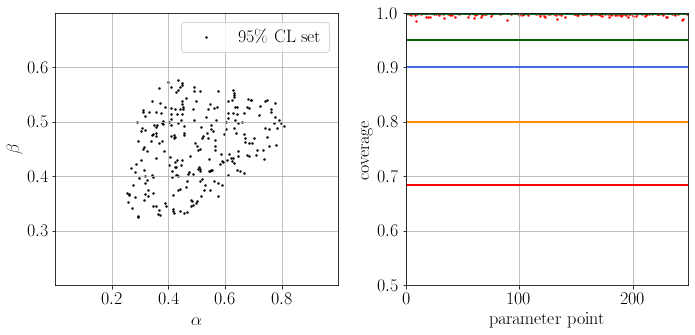

In [51]:
gfile = '../images/fig_SIR_quantile_coverage.pdf'
SIRdata.xmin = SIRdata.alpha_min
SIRdata.xmax = SIRdata.alpha_max
SIRdata.xlabel = '\\alpha'

SIRdata.ymin = SIRdata.beta_min
SIRdata.ymax = SIRdata.beta_max
SIRdata.ylabel = '\\beta'

plot_coverage(alpha, beta, N, cov, SIRdata, filename=gfile)